In [56]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from config import get_password

# retrieve password
password = get_password()

In [57]:
q = 'SELECT dt, adj_close, symbol from price_history;'

# Connect to postgres financial_data database
con = psycopg2.connect(
            host="localhost",
            database="financial_data",
            user='postgres',
            password=f'{password}')

# create cursor
c = con.cursor()

c.execute(q)
columns = [item[0] for item in c.description]
df = pd.DataFrame(c.fetchall(), columns=columns)

# close connection
con.close()

In [58]:
df.set_index("dt", inplace=True)

In [59]:
symb_data = df.groupby("symbol").get_group("NVDA")

In [60]:
sma_distances = [168, 504]
sma_cols = [symb_data["adj_close"].rolling(dist).mean() for dist in sma_distances]

In [61]:
for i in range(len(sma_cols)):
    col_len = len(symb_data.columns)
    col_name = f'sma_{sma_distances[i]}h'
    col_data = sma_cols[i]
    symb_data.insert(col_len, col_name, col_data)

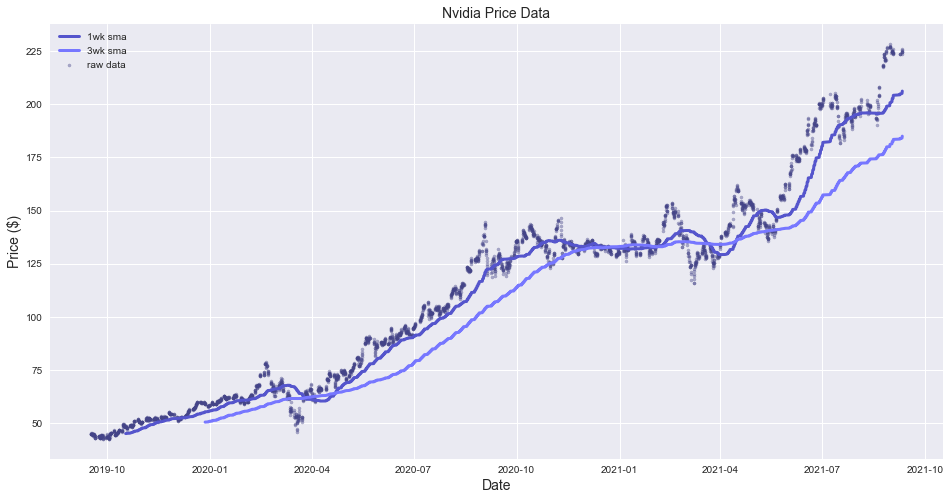

In [106]:
plt.figure(figsize=(16, 8))
plt.scatter(symb_data.index, symb_data["adj_close"], s=10, alpha=.4, c="#444488", label='raw data')
plt.plot(symb_data["sma_168h"], linewidth=3, color="#5555cc", label='1wk sma')
plt.plot(symb_data["sma_504h"], linewidth=3, color="#7777ff", label='3wk sma')

plt.title("Nvidia Price Data", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend()
plt.show()